# **LAB#7 JackBlack**

# Repositorio - https://github.com/CSeguraIbarra/IA-SIS420/tree/91cb981e9c2be4601471c7c0b59431d42cb5f5d0/laboratorio07
# Estudiantes :
## Nava Siñani Kelvin Jherman

## Segura Ibarra Cristhian


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
import math

class player:
    def play_game(self, q_or_H, num_episodes):
        env = gym.make("Blackjack-v1", natural=False, sab=False)
        wins = 0
        losses = 0
        draws = 0
        
        for _ in range(num_episodes):
            state, _ = env.reset()
            terminated = False
            
            while not terminated:
                if len(q_or_H.shape) == 1:  # Si es H
                    pi = np.exp(q_or_H - np.max(q_or_H))
                    pi /= np.sum(pi)
                    action = np.random.choice([0, 1], p=pi)
                else:  # Si es Q-table
                    action = np.argmax(q_or_H[state[0], state[1], state[2], :])
                
                next_state, reward, terminated, _, _ = env.step(action)
                
                if terminated:
                    if reward > 0:
                        wins += 1
                    elif reward < 0:
                        losses += 1
                    else:
                        draws += 1
                        
        env.close()
        
        print(f"Partidas jugadas: {num_episodes}")
        print(f"Victorias: {wins}")
        print(f"Derrotas: {losses}")
        print(f"Empates: {draws}")



# Define las clases para los diferentes métodos
class ActionValueMethod:
    def __init__(self):
        self.action_counts = None  # Contador de las veces que se ha seleccionado cada acción
        self.q_values = None  # Suma de recompensas acumuladas para cada acción

    def initialize_q_table(self):
        return np.zeros((32, 11, 2, 2))

    def select_action(self, q_table, state,i):
        if self.q_values is None:
            self.q_values = np.zeros(q_table.shape)
            self.action_counts = np.zeros(q_table.shape[3])
        return np.argmax(q_table[state[0], state[1], state[2], :])

    def update_q(self, q_table, state, action, reward,t):
        if self.q_values is None:
            self.q_values = np.zeros(q_table.shape)
            self.action_counts = np.zeros(q_table.shape[3])

        # Incrementa el contador para la acción seleccionada
        self.action_counts[action] += 1
        # Actualiza la suma de recompensas acumuladas para la acción seleccionada
        self.q_values[state[0], state[1], state[2], action] += reward

        # Calcula el valor medio de la acción
        q_table[state[0], state[1], state[2], action] = (
            self.q_values[state[0], state[1], state[2], action] / self.action_counts[action]
        )
    

class IncrementalMethod:
    def __init__(self, alpha):
        self.alpha = alpha  # Tasa de aprendizaje

    def initialize_q_table(self):
        return np.zeros((32, 11, 2, 2))

    def select_action(self, q_table, state,i):
        return np.argmax(q_table[state[0], state[1], state[2], :])

    def update_q(self, q_table, state, action, reward,t):
        # Actualiza el valor de Q utilizando la fórmula incremental
        q_table[state[0], state[1], state[2], action] += self.alpha * (reward - q_table[state[0], state[1], state[2], action])

class OptimisticInitialValuesMethod:
    def __init__(self, initial_value, alpha):
        self.initial_value = initial_value
        self.alpha = alpha

    def initialize_q_table(self):
        return np.full((32, 11, 2, 2), self.initial_value)

    def select_action(self, q_table, state,i):
        return np.argmax(q_table[state[0], state[1], state[2], :])

    def update_q(self, q_table, state, action, reward,t):
        q_table[state[0], state[1], state[2], action] += self.alpha * (reward - q_table[state[0], state[1], state[2], action])

class UCBMethod:
    def __init__(self, c, alpha):
        self.c = c  # Parámetro de exploración UCB
        self.alpha = alpha  # Tasa de aprendizaje
        self.action_counts = None  # Contador de las veces que se ha seleccionado cada acción
        self.q_values = None  # Valores Q estimados

    def initialize_q_table(self):
        return np.zeros((32, 11, 2, 2))

    def select_action(self, q_table, state, t):
        if self.action_counts is None:
            self.action_counts = np.zeros(q_table.shape[3])
            self.q_values = np.zeros(q_table.shape[3])
        
        ucb_values = np.zeros(q_table[state].shape)

        for a in range(ucb_values.shape[0]):
            exploration_bonus = self.c * math.sqrt(math.log(t + 1) / self.action_counts[a])
            ucb_values[a] = self.q_values[a] + exploration_bonus
        
        return np.argmax(ucb_values)

    def update_q(self, q_table, state, action, reward,t):
        if self.action_counts is None:
            self.action_counts = np.zeros(q_table.shape[3])
            self.q_values = np.zeros(q_table.shape[3])
        
        self.action_counts[action] += 1
        self.q_values[action] += self.alpha * (reward - self.q_values[action])

        q_table[state[0], state[1], state[2], action] = self.q_values[action]

class GradientAscentMethod:
    def __init__(self, alpha):
        self.alpha = alpha  # Tasa de aprendizaje
        self.H = np.zeros(2)  # Inicialización de las preferencias H para las acciones 0 y 1
        self.avg_reward = 0  # Recompensa media

    def initialize_q_table(self):
        return np.zeros((32, 11, 2, 2))

    def softmax(self, H):
        exp_values = np.exp(H - np.max(H))  # Para estabilidad numérica
        return exp_values / np.sum(exp_values)

    def select_action(self, q_table, state, t):
        pi = self.softmax(self.H)
        return np.random.choice([0, 1], p=pi)

    def update_q(self, q_table, state, action, reward,t):
        pi = self.softmax(self.H)
        self.avg_reward = (1 / (t + 1)) * (reward + t * self.avg_reward)
        if action == 0:
            self.H[action] += self.alpha * (reward - self.avg_reward) * (1 - pi[action])
        else:
            self.H[action] += self.alpha * (reward - self.avg_reward) * (-pi[action])

def train(episodes, method):
    # Inicializa el entorno de Blackjack
    env = gym.make("Blackjack-v1", natural=False, sab=False)

    # Define los parámetros del algoritmo q_table-learning
    learning_rate = 0.1  # Tasa de aprendizaje
    discount_factor = 0.95  # Factor de descuento para las recompensas
    epsilon = 1.0  # Probabilidad inicial de exploración (acciones aleatorias)
    epsilon_decay_rate = 0.0001  # Tasa de decaimiento de epsilon para reducir la exploración con el tiempo
    rng = np.random.default_rng()  # Generador de números aleatorios

    # Inicializa la tabla q_table con ceros para todas las combinaciones estado-acción o preferencias H
    q_table = method.initialize_q_table()
    # Inicializa un array para almacenar las recompensas obtenidas en cada episodio
    rewards_per_episode = np.zeros(episodes)

    # Bucle principal de entrenamiento
    for i in range(episodes):
        # Alterna entre modos con y sin renderización cada 1000 episodios
        if (i + 1) % 1000 == 0:
            env.close()
            env = gym.make("Blackjack-v1", render_mode="human")
            visualize = True
        else:
            env.close()
            env = gym.make("Blackjack-v1")
            visualize = False
        
        # Reinicia el entorno y obtiene el estado inicial
        state, _ = env.reset()
        terminated = False

        # Bucle para cada paso dentro de un episodio
        while not terminated:
            # Tomar una acción en base a si es exploración o explotación basado en epsilon
            if not isinstance(method, (UCBMethod, GradientAscentMethod)) and rng.random() < epsilon:
                action = env.action_space.sample()  # Exploración: selecciona una acción aleatoria
            else:
                action = method.select_action(q_table, state, i)

            # Realiza la acción y obtiene el nuevo estado y recompensa
            next_state, reward, terminated, _, _ = env.step(action)

            # Actualiza Q con el método seleccionado
            method.update_q(q_table, state, action, reward, i)

            # Actualiza el estado para la siguiente acción
            state = next_state

            # Renderiza el entorno si es necesario para visualización
            if visualize:
                env.render()
                time.sleep(1)  # Pausa de 1 segundo para ralentizar la visualización

        # Reduce el epsilon para disminuir la exploración a lo largo del tiempo
        epsilon = max(epsilon - epsilon_decay_rate, 0)

        # Registra la recompensa obtenida en este episodio
        rewards_per_episode[i] = reward

        # Imprime el progreso cada 1000 episodios
        if (i + 1) % 1000 == 0:
            print(f"Episodio: {i + 1} - Recompensa: {reward}")

    # Cierra el entorno al finalizar el entrenamiento
    env.close()

    # Imprime la tabla Q o preferencias H final
    if isinstance(method, GradientAscentMethod):
        print(f"Mejor H: {method.H}")
        print("Preferencias H final:")
        for action in range(len(method.H)):
            print(f"H[{action}] = {method.H[action]}")
    else:
        print(f"Mejor Q: {q_table}")
        print("Tabla Q final:")
        for i in range(q_table.shape[0]):
            for j in range(q_table.shape[1]):
                for k in range(q_table.shape[2]):
                    for l in range(q_table.shape[3]):
                        print(f"q_table[{i}, {j}, {k}, {l}] = {q_table[i, j, k, l]}")

    # Calcula y muestra la suma de recompensas acumuladas en bloques de 100 episodios
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t - 1000):(t + 1)])
    plt.plot(sum_rewards)
    plt.xlabel('Episodios')
    plt.ylabel('Recompensas en bloques de 1000 episodios')
    plt.title('Evolución')
    plt.show()

    # Evaluación utilizando la clase player
    player_instance = player()
    if isinstance(method, GradientAscentMethod):
        player_instance.play_game(method.H, num_episodes=1000)  # Cambia num_episodes según tus necesidades
    else:
        player_instance.play_game(q_table, num_episodes=1000)  # Cambia num_episodes según tus necesidades


Episodio: 1000 - Recompensa: 1.0
Episodio: 2000 - Recompensa: 1.0
Episodio: 3000 - Recompensa: -1.0
Episodio: 4000 - Recompensa: -1.0
Episodio: 5000 - Recompensa: 1.0
Episodio: 6000 - Recompensa: 1.0
Episodio: 7000 - Recompensa: -1.0
Episodio: 8000 - Recompensa: -1.0
Episodio: 9000 - Recompensa: -1.0
Episodio: 10000 - Recompensa: -1.0
Episodio: 11000 - Recompensa: -1.0
Episodio: 12000 - Recompensa: -1.0
Episodio: 13000 - Recompensa: 1.0
Episodio: 14000 - Recompensa: 1.0
Episodio: 15000 - Recompensa: 1.0
Episodio: 16000 - Recompensa: -1.0
Episodio: 17000 - Recompensa: -1.0
Episodio: 18000 - Recompensa: -1.0
Episodio: 19000 - Recompensa: -1.0
Episodio: 20000 - Recompensa: -1.0
Episodio: 21000 - Recompensa: 0.0
Episodio: 22000 - Recompensa: -1.0
Episodio: 23000 - Recompensa: 1.0
Episodio: 24000 - Recompensa: 1.0
Episodio: 25000 - Recompensa: 1.0
Episodio: 26000 - Recompensa: 1.0
Episodio: 27000 - Recompensa: 1.0
Episodio: 28000 - Recompensa: -1.0
Episodio: 29000 - Recompensa: 0.0
Episodio

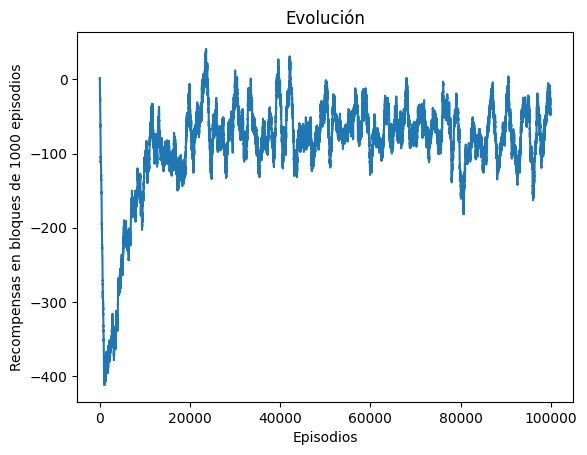

Partidas jugadas: 1000
Victorias: 257
Derrotas: 682
Empates: 61


In [2]:
# Ejecuta la función de entrenamiento si el script es el programa principal
if __name__ == "__main__":
    train(100000, ActionValueMethod())

Episodio: 1000 - Recompensa: 1.0
Episodio: 2000 - Recompensa: -1.0
Episodio: 3000 - Recompensa: -1.0
Episodio: 4000 - Recompensa: -1.0
Episodio: 5000 - Recompensa: -1.0
Episodio: 6000 - Recompensa: 1.0
Episodio: 7000 - Recompensa: 1.0
Episodio: 8000 - Recompensa: 1.0
Episodio: 9000 - Recompensa: 1.0
Episodio: 10000 - Recompensa: -1.0
Episodio: 11000 - Recompensa: 1.0
Episodio: 12000 - Recompensa: -1.0
Episodio: 13000 - Recompensa: 1.0
Episodio: 14000 - Recompensa: -1.0
Episodio: 15000 - Recompensa: -1.0
Episodio: 16000 - Recompensa: 1.0
Episodio: 17000 - Recompensa: -1.0
Episodio: 18000 - Recompensa: -1.0
Episodio: 19000 - Recompensa: -1.0
Episodio: 20000 - Recompensa: -1.0
Episodio: 21000 - Recompensa: -1.0
Episodio: 22000 - Recompensa: -1.0
Episodio: 23000 - Recompensa: 1.0
Episodio: 24000 - Recompensa: 1.0
Episodio: 25000 - Recompensa: 1.0
Episodio: 26000 - Recompensa: 1.0
Episodio: 27000 - Recompensa: 1.0
Episodio: 28000 - Recompensa: 1.0
Episodio: 29000 - Recompensa: -1.0
Episodio

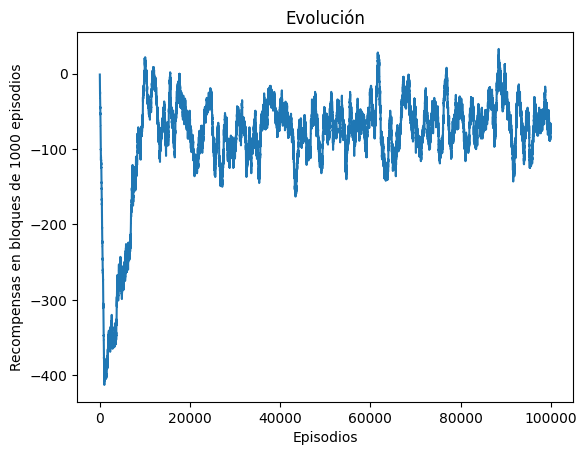

Partidas jugadas: 1000
Victorias: 227
Derrotas: 727
Empates: 46


In [3]:
train(100000, IncrementalMethod(alpha=0.1))

Episodio: 1000 - Recompensa: -1.0
Episodio: 2000 - Recompensa: 1.0
Episodio: 3000 - Recompensa: 1.0
Episodio: 4000 - Recompensa: 1.0
Episodio: 5000 - Recompensa: 1.0
Episodio: 6000 - Recompensa: 1.0
Episodio: 7000 - Recompensa: -1.0
Episodio: 8000 - Recompensa: 1.0
Episodio: 9000 - Recompensa: 1.0
Episodio: 10000 - Recompensa: 0.0
Episodio: 11000 - Recompensa: -1.0
Episodio: 12000 - Recompensa: -1.0
Episodio: 13000 - Recompensa: -1.0
Episodio: 14000 - Recompensa: 1.0
Episodio: 15000 - Recompensa: -1.0
Episodio: 16000 - Recompensa: 1.0
Episodio: 17000 - Recompensa: -1.0
Episodio: 18000 - Recompensa: -1.0
Episodio: 19000 - Recompensa: -1.0
Episodio: 20000 - Recompensa: 1.0
Episodio: 21000 - Recompensa: 0.0
Episodio: 22000 - Recompensa: 1.0
Episodio: 23000 - Recompensa: 1.0
Episodio: 24000 - Recompensa: 1.0
Episodio: 25000 - Recompensa: 1.0
Episodio: 26000 - Recompensa: -1.0
Episodio: 27000 - Recompensa: -1.0
Episodio: 28000 - Recompensa: 0.0
Episodio: 29000 - Recompensa: 1.0
Episodio: 30

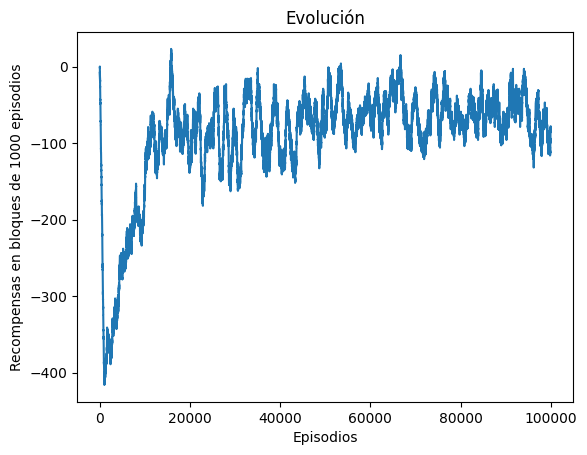

Partidas jugadas: 1000
Victorias: 191
Derrotas: 750
Empates: 59


In [4]:
train(100000, OptimisticInitialValuesMethod(initial_value=5.0, alpha=0.1))

C:\Users\kiens\AppData\Local\Temp\ipykernel_8352\2129958552.py:122: RuntimeWarning: invalid value encountered in scalar divide
  exploration_bonus = self.c * math.sqrt(math.log(t + 1) / self.action_counts[a])
C:\Users\kiens\AppData\Local\Temp\ipykernel_8352\2129958552.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  exploration_bonus = self.c * math.sqrt(math.log(t + 1) / self.action_counts[a])


Episodio: 1000 - Recompensa: -1.0
Episodio: 2000 - Recompensa: -1.0
Episodio: 3000 - Recompensa: -1.0
Episodio: 4000 - Recompensa: -1.0
Episodio: 5000 - Recompensa: -1.0
Episodio: 6000 - Recompensa: -1.0
Episodio: 7000 - Recompensa: -1.0
Episodio: 8000 - Recompensa: -1.0
Episodio: 9000 - Recompensa: -1.0
Episodio: 10000 - Recompensa: -1.0
Episodio: 11000 - Recompensa: -1.0
Episodio: 12000 - Recompensa: -1.0
Episodio: 13000 - Recompensa: -1.0
Episodio: 14000 - Recompensa: -1.0
Episodio: 15000 - Recompensa: -1.0
Episodio: 16000 - Recompensa: -1.0
Episodio: 17000 - Recompensa: -1.0
Episodio: 18000 - Recompensa: -1.0
Episodio: 19000 - Recompensa: -1.0
Episodio: 20000 - Recompensa: 1.0
Episodio: 21000 - Recompensa: 1.0
Episodio: 22000 - Recompensa: -1.0
Episodio: 23000 - Recompensa: 1.0
Episodio: 24000 - Recompensa: 1.0
Episodio: 25000 - Recompensa: -1.0
Episodio: 26000 - Recompensa: 0.0
Episodio: 27000 - Recompensa: 1.0
Episodio: 28000 - Recompensa: 1.0
Episodio: 29000 - Recompensa: 1.0
Ep

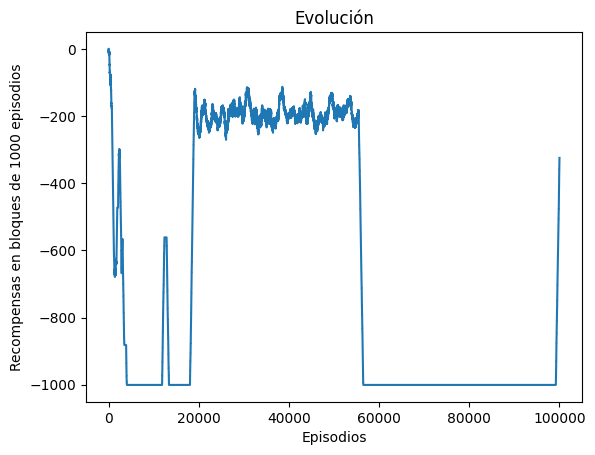

Partidas jugadas: 1000
Victorias: 367
Derrotas: 585
Empates: 48


In [7]:
train(100000, UCBMethod(c=1, alpha=0.1))

Episodio: 1000 - Recompensa: -1.0
Episodio: 2000 - Recompensa: 1.0
Episodio: 3000 - Recompensa: 1.0
Episodio: 4000 - Recompensa: 1.0
Episodio: 5000 - Recompensa: -1.0
Episodio: 6000 - Recompensa: 1.0
Episodio: 7000 - Recompensa: 1.0
Episodio: 8000 - Recompensa: -1.0
Episodio: 9000 - Recompensa: -1.0
Episodio: 10000 - Recompensa: 1.0
Episodio: 11000 - Recompensa: 1.0
Episodio: 12000 - Recompensa: -1.0
Episodio: 13000 - Recompensa: 0.0
Episodio: 14000 - Recompensa: -1.0
Episodio: 15000 - Recompensa: 0.0
Episodio: 16000 - Recompensa: -1.0
Episodio: 17000 - Recompensa: 0.0
Episodio: 18000 - Recompensa: 1.0
Episodio: 19000 - Recompensa: 0.0
Episodio: 20000 - Recompensa: -1.0
Episodio: 21000 - Recompensa: -1.0
Episodio: 22000 - Recompensa: -1.0
Episodio: 23000 - Recompensa: -1.0
Episodio: 24000 - Recompensa: -1.0
Episodio: 25000 - Recompensa: -1.0
Episodio: 26000 - Recompensa: -1.0
Episodio: 27000 - Recompensa: 1.0
Episodio: 28000 - Recompensa: -1.0
Episodio: 29000 - Recompensa: -1.0
Episodi

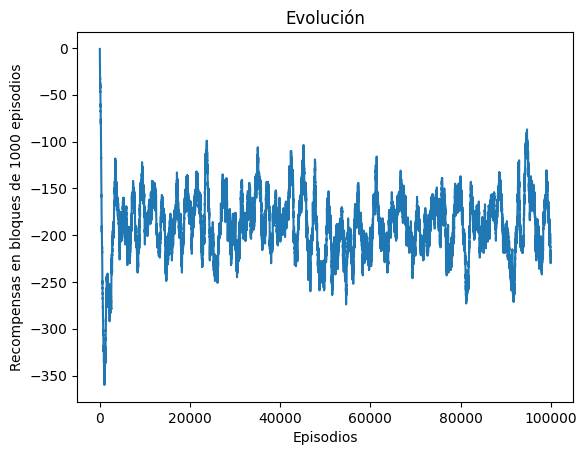

Partidas jugadas: 1000
Victorias: 385
Derrotas: 572
Empates: 43


In [6]:
train(100000, GradientAscentMethod(alpha=0.1))